In [1]:
import os, sys
import pickle
sys.path.append("../")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from tqdm import *

from grf.grf import PerturbedProbability, FIRAS
from grf.pk_interp import PowerSpectrumGridInterpolator
from grf.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load plot settings

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Extracting $\mathrm{d}P/\mathrm{d}z$

This notebook will describe how to extract the central quantity in the paper, the differential conversion probability, using the provided code.

## 1. Loading a power spectrum object `PowerSpectrumGridInterpolator`

The class `PowerSpectrumGridInterpolator` provides an interface to extract power spectra pre-computed using CLASS. It can be instantiated with a single string argument giving the name of the pre-computed power spectrum. The notebook `notebooks/01_franken_PS.ipynb` described how the power spectra are generated and saved. Spectra are generated up to $k = 1000\,h\,$Mpc$^{-1}$ and extrapolated beyond this.

The class can be instantiated by default with one of the following arguments:
- `"nonlin_matter"`: nonlinear matter power spectrum
- `"nonlin_matter_bj"`: nonlinear matter spectrum with a baryon Jeans scale suppression
- `"lin_matter"`: linear matter power spectrum
- `"lin_baryon"`: linear baryon power spectrum
- `"franken_upper"`: upper bound on inferred baryonic power spectrum extracted from simulations (PS$_\mathrm{max}$ prescription)
- `"franken_lower"`: lower bound on inferred baryonic power spectrum extracted from simulations (PS$_\mathrm{min}$ prescription)

In [3]:
# Load nonlinear matter spectrum with a baryon Jeans scale suppression
log_pspec = PowerSpectrumGridInterpolator("nonlin_matter_bj")

This is an instance of a `RegularGridInterpolator` array which takes redshift $z$ and scale $k$ (units $h\,$Mpc$^{-1}$) arrays as inputs, and outputs a $\log_{10}(z, k)$ matrix of shape `(len(z), len(k))` in units Mpc$^3\,h^{-3}$.

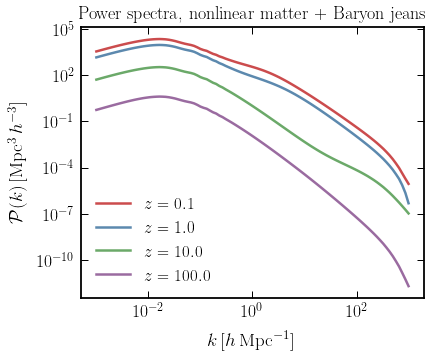

In [4]:
z_ary = np.array([0.1, 1, 10, 100])
k_ary = np.logspace(-3, 3, 100)

log_pspec_ary = log_pspec(z_ary, k_ary)

for i_z in range(len(z_ary)):
    plt.plot(k_ary, 10 ** (log_pspec_ary)[i_z], label='$z=' + str(z_ary[i_z]) + '$')

plt.xlabel("$k\,[h\,\mathrm{Mpc}^{-1}]$")
plt.ylabel("$\mathcal P(k)$\,[Mpc$^3$\,$h^{-3}$]")

plt.xscale("log")
plt.yscale("log")

plt.title("Power spectra, nonlinear matter + Baryon jeans")

plt.legend()

Load Analytic pdf described in https://arxiv.org/abs/1811.07913. This again is an `RegularGridInterpolator` instance which takes ($\log_{10}$ of) a redshift array as first argument, a $1 + \delta$ as second argument and outputs a mesh of the $\log_{10}$ of the pdf. This is made in `notebooks/04_analytic_pdf.ipynb`.

In [5]:
log_analytic_pdf_interp = pickle.load(open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'rb'))

Load `PerturbedProbability` class instance with already-loaded power spectrum.

## 2. Extract and plot $\mathrm{d}P/\mathrm{d}z$

In [6]:
prob = PerturbedProbability(log_pspec)
firas = FIRAS(log_pspec)  # Also load a FIRAS class to access the FIRAS frequencies, as benchmarks

../grf/grf.py:532: FutureWarning: read_table is deprecated, use read_csv instead.
  names =['freq', 'I', 'residual', 'uncert', 'poles'])


The following docstring summarizes the inputs to the function `PerturbedProbability._dP_dz()`, used to compute the differential conversion probability, and its outputs. Where natural units are specified, they use $\mathrm{keV}=1$ as base unit.

```py
        :param z_ary: Array of redshifts over which to calculate dP/dz
        :param m_Ap: Dark photon mass in natural units
        :param k_min: Minimum scale in h/Mpc
        :param k_max: Maximum scale in h/Mpc
        :param omega: Array of frequencies, in natural units
        :param pdf: Distribution of perturbations. 'gaussian', 'lognormal', 'voids', or a `RegularGridInterpolator` instance for a custom pdf.
        :param one_plus_delta_bound: Restrict to fluctuations (1 + \delta) times and divided by this quantity
        :param b: Bias parameter for lognormal pdf
        :param Ap_DM: Dark photon dark matter case
        :param x_e_ary: An optional custom ionization fraction array of same length at z_ary
        :param eng_weight: Weight dP/dz by m_Ap ** 2 /m_A_sq, for dark photon -> photon energy injection case. 
        :param r_smooth: Smoothing scale, by default no smoothing
        :param return_pdf: Whether to return pdf
        :return: dP_dz_ary, sigma_sq_ary (in natural units), (optionally) pdf_ary
```

Output arrays are of shape `(n_freq, n_redshifts)`.

In [7]:
# Dark photon mass 
m_Ap = 1e-13 * eV  

# Frequencies of interest (we are only going to plot results corresponding to the lower frequency)
omega_ary = firas.omega_FIRAS

# Get homogeneous crossings, to see where they are!
z_homogeneous_crossings = prob.get_z_crossings(m_Ap, omega_ary[0])

../grf/grf.py:315: RuntimeWarning: invalid value encountered in log
  pdf_ary = 1 / np.sqrt(2 * np.pi * sigma_LN_sq_ary) * np.exp(-(np.log(1 / b * (m_Ap ** 2 / m_A_sq + b - 1)) + sigma_LN_sq_ary / 2.) ** 2 / (2 * sigma_LN_sq_ary)) * (1. / (m_Ap ** 2 + (b - 1) * m_A_sq))
../grf/grf.py:317: RuntimeWarning: invalid value encountered in log
  dP_dz_ary = 1 / np.sqrt(2 * np.pi * sigma_LN_sq_ary) * np.exp(-(np.log(1 / b * (m_Ap ** 2 / m_A_sq + b - 1)) + sigma_LN_sq_ary / 2.) ** 2 / (2 * sigma_LN_sq_ary)) / np.abs(self.dz_dt(z_mesh)) * (m_Ap ** 2 / (m_Ap ** 2 + (b - 1) * m_A_sq))
../grf/grf.py:395: RuntimeWarning: invalid value encountered in log10
  log_pdf = pdf(np.log10(input_ary))


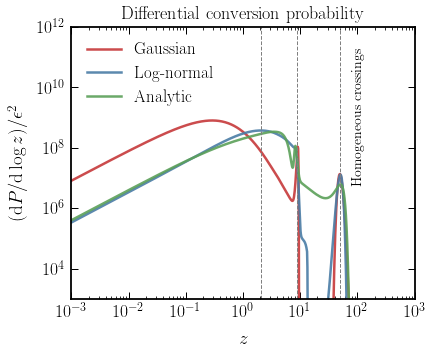

In [8]:
z_ary = np.logspace(-3, 3, 1000)

# Using Gaussian PDF
plt.plot(z_ary, z_ary * prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='gaussian')[0][0], label="Gaussian")

# Using log-normal PDF
plt.plot(z_ary, z_ary * prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf='lognormal')[0][0], label="Log-normal")

# Using analytic PDF
plt.plot(z_ary, z_ary * prob._dP_dz(z_ary=z_ary, m_Ap=m_Ap, k_min=1e-3, k_max=1e3, omega=omega_ary, pdf=log_analytic_pdf_interp)[0][0], label="Analytic")

for z_cross in z_homogeneous_crossings:
    plt.axvline(z_cross, ls='--', lw=1, color='grey')

plt.text(80, 1e11, "Homogeneous crossings", rotation=90, fontsize=14)
plt.xscale("log")
plt.yscale("log")

plt.xlim(min(z_ary), max(z_ary))
plt.ylim(1e3, 1e12)

plt.xlabel("$z$")
plt.ylabel(r"$(\mathrm{d}P/\mathrm{d}\log z)/\epsilon^2$")

plt.title("Differential conversion probability")

plt.legend()